In [1]:
#pip install nltk

In [2]:
#pip install Sastrawi

In [3]:
import pandas as pd
import numpy as np

import re, collections
import string
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
import nltk 

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/Lenovo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/Lenovo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/Lenovo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
data_raw = pd.read_csv('gs://cloud-ai-platform-7bfc6536-211b-4cb2-a204-749e10e46074/dataset_esay_grading.csv')

In [6]:
data_raw.head()

,jawaban_mahasiswa,jawaban_dosen,human_rater,human_rater_scaled
0,komputer menggunakan layanan tersedia jaringan,client server jaringan komputer model komunika...,20,0.2
1,fundamental centralized infrastructure,client server jaringan komputer model komunika...,20,0.2
2,hubungan komponen jaringan berkomunikasi,client server jaringan komputer model komunika...,30,0.3
3,client server jaringan komunikasi client serve...,client server jaringan komputer model komunika...,40,0.4
4,client server jaringan 2 buah cliet 1 server s...,client server jaringan komputer model komunika...,40,0.4


In [7]:
def preprocessing_text(df):
    factory = StopWordRemoverFactory()
    stopword = factory.create_stop_word_remover()

    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    new_data = []
    exclude = ['', '"', '”']

    df['jawaban_mahasiswa'] = df['jawaban_mahasiswa'].str.strip().str.lower()
    df['jawaban_dosen'] = df['jawaban_dosen'].str.strip().str.lower()
    
    for index, row in df.iterrows():
        label = row['human_rater']
        sentence_mahasiswa = row['jawaban_mahasiswa']
        # sentence_dosen = row['jawaban_dosen']
        ## === menghilangkan kata yang dianggap tidak mengacu pada inti kalimatnya, seperti kata sang, si, dan, itu, dan lain sebagainya
        sentence_mahasiswa = stopword.remove(sentence_mahasiswa)
        # sentence_dosen = stopword.remove(sentence_dosen)

        ## === mentransformasi kata-kata pada text menjadi kata dasarnya
        sentence_mahasiswa = stemmer.stem(sentence_mahasiswa)
        # sentence_dosen = stemmer.stem(sentence_dosen)
        # sentence = sentence_stemming if sentence_stopwords == "" or sentence_stopwords == " " else sentence_stopwords

        df.at[index, 'jawaban_mahasiswa']= sentence_mahasiswa
        # df.at[index, 'jawaban_dosen']= sentence_dosen

        # sentence = find_words = re.compile(r'(?<!\S)[A-Za-z]+(?!\S)|(?<!\S)[A-Za-z]+(?=:(?!\S))').findall
        # sentence = re.match("^[A-Za-z]*$", sentence):
        tokens_mahasiswa = nltk.tokenize.sent_tokenize(sentence_mahasiswa)
        # tokens_dosen = nltk.tokenize.sent_tokenize(sentence_dosen)

        if len(tokens_mahasiswa) > 1:
            print("here")
            test = []
            for i, token in enumerate(tokens):
                ## === splitting text menjadi beberapa kalimat berdasarkan tanda ? ! "" dengan split regex
                test += re.split(r'[!?"(.*?)"]+|(?<!\.)\.(?!\.)', token)

            ## === menghapus tanda baca dan number pada kalimat yang dihasilkan dengan substract regex
            tokens = [re.sub(r'[^\w]', ' ', i) for i in test if i not in exclude]

            ## === menghilangkan angka dengan substract regex
            tokens = [re.sub("(\s\d+)","",i)  for i in tokens]

            for i, token in enumerate(tokens):
                if token != '' or token != ' ' or token != "\"":

                    ## === menghilangkan duplicate words
                    token = ' '.join(dict.fromkeys(token.split()))

                    new_data.append([token, label])
    return df.copy()
       

In [8]:
data = preprocessing_text(data_raw)

In [9]:
data

,jawaban_mahasiswa,jawaban_dosen,human_rater,human_rater_scaled
0,komputer guna layan sedia jaring,client server jaringan komputer model komunika...,20,0.2
1,fundamental centralized infrastructure,client server jaringan komputer model komunika...,20,0.2
2,hubung komponen jaring komunikasi,client server jaringan komputer model komunika...,30,0.3
3,client server jaring komunikasi client server ...,client server jaringan komputer model komunika...,40,0.4
4,client server jaring 2 buah cliet 1 server sat...,client server jaringan komputer model komunika...,40,0.4
...,...,...,...,...
215,turbo boost sistem beri produsen prosesor ting...,turbo boost salah satu fitur prosesor masa ber...,70,0.7
216,turbo boost cepat kerja processor milik perfor...,turbo boost salah satu fitur prosesor masa ber...,80,0.8
217,turbo boost kondisi jadi tambah cepat prosesor...,turbo boost salah satu fitur prosesor masa ber...,60,0.6
218,turbo boost fitur prosesor tingkat kerja prose...,turbo boost salah satu fitur prosesor masa ber...,80,0.8


In [10]:
data.isnull().sum()

jawaban_mahasiswa     0
jawaban_dosen         0
human_rater           0
human_rater_scaled    0
dtype: int64

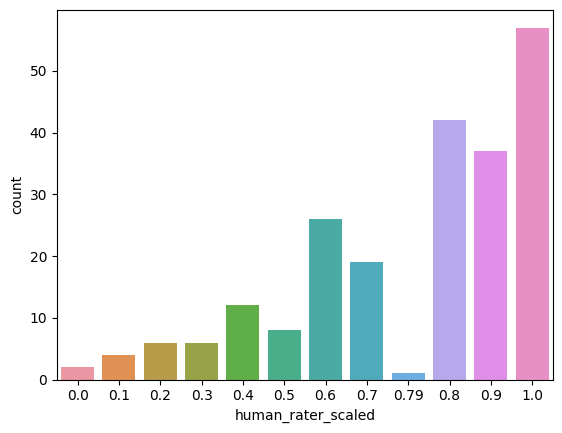

In [11]:
sns.countplot(x=data_raw.human_rater_scaled)
plt.show()

In [12]:
# Feature Extraction
# TFIDF dan Cosine Similarity 
# Feature Extraction
# TFIDF dan Cosine Similarity 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [13]:
#Pembuatan feature baru 

vec = TfidfVectorizer()
# vec = CountVectorizer()

similarity = []
for index, row in data.iterrows():
    corpus = [row['jawaban_mahasiswa'], row['jawaban_dosen']]
    sparse_matrix = vec.fit_transform(corpus)
    doc_term_matrix = sparse_matrix.todense()
    sim = cosine_similarity(sparse_matrix[0], sparse_matrix[1])
    similarity.append(sim[0][0])

data["similarity"] = similarity

In [14]:
data

,jawaban_mahasiswa,jawaban_dosen,human_rater,human_rater_scaled,similarity
0,komputer guna layan sedia jaring,client server jaringan komputer model komunika...,20,0.2,0.034600
1,fundamental centralized infrastructure,client server jaringan komputer model komunika...,20,0.2,0.000000
2,hubung komponen jaring komunikasi,client server jaringan komputer model komunika...,30,0.3,0.039225
3,client server jaring komunikasi client server ...,client server jaringan komputer model komunika...,40,0.4,0.252716
4,client server jaring 2 buah cliet 1 server sat...,client server jaringan komputer model komunika...,40,0.4,0.178612
...,...,...,...,...,...
215,turbo boost sistem beri produsen prosesor ting...,turbo boost salah satu fitur prosesor masa ber...,70,0.7,0.209181
216,turbo boost cepat kerja processor milik perfor...,turbo boost salah satu fitur prosesor masa ber...,80,0.8,0.153784
217,turbo boost kondisi jadi tambah cepat prosesor...,turbo boost salah satu fitur prosesor masa ber...,60,0.6,0.232294
218,turbo boost fitur prosesor tingkat kerja prose...,turbo boost salah satu fitur prosesor masa ber...,80,0.8,0.432760


Probability of Prediction (POP) Feature engineering method, this method using classification algorithm for extract the score of prediction. The classfication model, it will be obtain the word2vec and PCA and several classification model (LR, SVC, etc)

In [15]:

# Label encoding
x,y = np.asarray(data["jawaban_mahasiswa"]),np.asarray(data["jawaban_dosen"])
label_map = {cat:index for index,cat in enumerate(np.unique(y))}
y_prep = np.asarray([label_map[l] for l in y])

In [16]:
y_prep

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [17]:
# metode word embedding 
# tokenized each sentence into list
x_tokenized = [[w for w in sentence.split(" ") if w != ""] for sentence in x]
x_tokenized[0]

['komputer', 'guna', 'layan', 'sedia', 'jaring']

In [18]:
#Train word2vec model using Gensim library and x_tokenize data
import time
import gensim

start = time.time()

model = gensim.models.Word2Vec(x_tokenized,
                 vector_size=100
                 # Size is the length of our vector.
                )

end = round(time.time()-start,2)
print("This process took",end,"seconds.")

This process took 0.05 seconds.


In [19]:
model.wv.most_similar("komputer")

[('unit', 0.9994640946388245),
 ('memory', 0.9993798732757568),
 ('data', 0.999369204044342),
 ('turbo', 0.999276876449585),
 ('guna', 0.9992653727531433),
 ('program', 0.9992589950561523),
 ('kerja', 0.9992281198501587),
 ('alu', 0.9992130994796753),
 ('boost', 0.9992090463638306),
 ('processor', 0.9991937875747681)]

In [20]:
# class sequencer use for 

class Sequencer():

    def __init__(self,
                 all_words,
                 max_words,
                 seq_len,
                 embedding_matrix
                ):

        self.seq_len = seq_len
        self.embed_matrix = embedding_matrix
        """
        temp_vocab = Vocab which has all the unique words
        self.vocab = Our last vocab which has only most used N words.

        """
        temp_vocab = list(set(all_words))
        self.vocab = []
        self.word_cnts = {}
        """
        Now we'll create a hash map (dict) which includes words and their occurencies
        """
        for word in temp_vocab:
            # 0 does not have a meaning, you can add the word to the list
            # or something different.
            count = len([0 for w in all_words if w == word])
            self.word_cnts[word] = count
            counts = list(self.word_cnts.values())
            indexes = list(range(len(counts)))

        # Now we'll sort counts and while sorting them also will sort indexes.
        # We'll use those indexes to find most used N word.
        cnt = 0
        while cnt + 1 != len(counts):
            cnt = 0
            for i in range(len(counts)-1):
                if counts[i] < counts[i+1]:
                    counts[i+1],counts[i] = counts[i],counts[i+1]
                    indexes[i],indexes[i+1] = indexes[i+1],indexes[i]
                else:
                    cnt += 1

        for ind in indexes[:max_words]:
            self.vocab.append(temp_vocab[ind])

    def textToVector(self,text):
        # First we need to split the text into its tokens and learn the length
        # If length is shorter than the max len we'll add some spaces (100D vectors which has only zero values)
        # If it's longer than the max len we'll trim from the end.
        tokens = text.split()
        len_v = len(tokens)-1 if len(tokens) < self.seq_len else self.seq_len-1
        vec = []
        for tok in tokens[:len_v]:
            try:
                vec.append(self.embed_matrix[tok])
            except Exception as E:
                pass

        last_pieces = self.seq_len - len(vec)
        for i in range(last_pieces):
            vec.append(np.zeros(100,))

        return np.asarray(vec).flatten()

In [21]:
sequencer = Sequencer(all_words = [token for seq in x_tokenized for token in seq],
              max_words = 1200,
              seq_len = 15,
              embedding_matrix = model.wv
             )

In [22]:
# menguji sebuah kalimat menggunakan model word2vec
test_vec = sequencer.textToVector("aplikasi komputer")
test_vec

array([-0.07780912,  0.11008227,  0.01534857, ...,  0.        ,
        0.        ,  0.        ])

In [23]:
#shape of test_vec 
test_vec.shape

(1500,)

In [24]:
#text to vector model using x_tokenized data 
x_vecs = np.asarray([sequencer.textToVector(" ".join(seq)) for seq in x_tokenized])
x_vecs

array([[-0.21320371,  0.28749859,  0.02822648, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.06262442,  0.0955276 , -0.00230743, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.12521598,  0.17627819,  0.01268003, ...,  0.        ,
         0.        ,  0.        ],
       [-0.12521598,  0.17627819,  0.01268003, ...,  0.        ,
         0.        ,  0.        ],
       [-0.12521598,  0.17627819,  0.01268003, ...,  0.        ,
         0.        ,  0.        ]])

In [25]:
# After got a word2vec value, this list shape is very large, then using PCA for reducing the list 

from sklearn.decomposition import PCA
pca_model = PCA(n_components=50)
pca_model.fit(x_vecs)
print("Sum of variance ratios: ",sum(pca_model.explained_variance_ratio_))


Sum of variance ratios:  0.9974755381981186


In [26]:
x_comps = pca_model.transform(x_vecs)
x_comps.shape

(220, 50)

In [27]:
x_comps

array([[ 2.83374143e+00,  5.85188363e-01,  1.98410607e-01, ...,
         6.89464612e-03,  1.38056103e-02,  5.59255782e-03],
       [ 3.35753414e+00,  1.76334156e+00, -8.82698617e-02, ...,
         1.88823012e-03, -7.03919581e-03, -4.56286607e-03],
       [ 3.11609395e+00,  1.32231063e+00, -8.38153923e-02, ...,
        -1.24406475e-02, -5.26536419e-03, -8.16085418e-03],
       ...,
       [ 1.22482894e+00, -1.04903280e+00,  2.70006624e-01, ...,
         1.48425133e-02,  6.81644296e-03, -2.12293240e-02],
       [-1.49554377e+00,  6.22420281e-01,  2.96802465e-01, ...,
        -4.34941791e-03, -1.06797453e-02, -2.21497466e-04],
       [ 1.15496573e+00, -7.76494299e-01,  3.78112116e-01, ...,
        -5.68524946e-03, -8.81611546e-03, -2.07062584e-02]])

In [29]:
#After PCA Data is ready, then with using train test split for split data into 80% data train and 20% data test
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(x_comps,y_prep,test_size=0.2,random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(176, 50)
(44, 50)
(176,)
(44,)


Training and testing dataset using classification algorithm
This classification algorithm for get the probability of classfication 

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.svm import SVC

svm_classifier = SVC()
svm_classifier.fit(x_train,y_train)
print("Score of SVM",svm_classifier.score(x_test,y_test))

rfc = RandomForestClassifier()
rfc.fit(x_train,y_train)
print("Score of RFC",rfc.score(x_test,y_test))

gbc = GradientBoostingClassifier()
gbc.fit(x_train, y_train)
print("Score of GradBoost",gbc.score(x_test,y_test))

abc = AdaBoostClassifier()
abc.fit(x_train, y_train)
print("Score of AdaBoost",abc.score(x_test,y_test))

dtc = DecisionTreeClassifier()
dtc.fit(x_train,y_train)
print("Score of DT",dtc.score(x_test,y_test))

logreg = LogisticRegression()
logreg.fit(x_train,y_train)
print("Score of LogReg",logreg.score(x_test,y_test))

gnb = GaussianNB()
gnb.fit(x_train,y_train)
print("Score of GaussianNB",gnb.score(x_test,y_test))

bnb = BernoulliNB()
bnb.fit(x_train,y_train)
print("Score of BernoulliNB",bnb.score(x_test,y_test))

knn = KNeighborsClassifier(7)
knn.fit(x_train,y_train)
print("Score of KNN",knn.score(x_test,y_test))


Score of SVM 0.5454545454545454
Score of RFC 0.9318181818181818
Score of GradBoost 0.9545454545454546
Score of AdaBoost 0.7727272727272727
Score of DT 0.7954545454545454
Score of LogReg 0.5
Score of GaussianNB 0.9318181818181818
Score of BernoulliNB 0.8181818181818182
Score of KNN 0.36363636363636365


Feature engineering using probabity of prediction 

In [33]:
# because the Gradient Boosting classification is the highest score, extraction of feature value using this algorithm. 
# probability of prediction (POP)
pop = gbc.predict_proba(x_comps)

In [34]:
gbc.classes_

array([0, 1, 2, 3])

In [37]:
pop[:,0]

array([9.99410760e-01, 3.32837196e-01, 9.99470351e-01, 9.99924572e-01,
       9.99907382e-01, 9.99942146e-01, 9.99861714e-01, 9.99818906e-01,
       9.99483025e-01, 9.99915427e-01, 9.99908020e-01, 9.99941155e-01,
       9.99939602e-01, 9.99923164e-01, 9.99827952e-01, 9.99890357e-01,
       9.83721206e-01, 9.99919954e-01, 9.99916005e-01, 9.99755940e-01,
       9.99931851e-01, 9.99878048e-01, 9.99863464e-01, 9.99928336e-01,
       9.99904942e-01, 9.96878561e-01, 9.99928874e-01, 9.99951011e-01,
       9.99873878e-01, 9.99929623e-01, 9.97570946e-01, 9.99949062e-01,
       9.99890818e-01, 9.99953153e-01, 9.99893030e-01, 9.99728529e-01,
       9.99957208e-01, 9.99780110e-01, 9.99938168e-01, 9.99894178e-01,
       9.99955716e-01, 9.99944071e-01, 9.99602270e-01, 9.99917552e-01,
       9.99919005e-01, 9.98920776e-01, 9.99568897e-01, 9.99850390e-01,
       9.99940815e-01, 9.99831080e-01, 9.99937858e-01, 9.99887508e-01,
       9.99914845e-01, 9.99904160e-01, 9.99709238e-01, 4.80076616e-06,
      

In [38]:
df_new = data.copy()
df_new["probability"] = pop[:,0] # clf.predict_proba(X_test)

                                     jawaban_mahasiswa  \
0                     komputer guna layan sedia jaring   
1               fundamental centralized infrastructure   
2                    hubung komponen jaring komunikasi   
3    client server jaring komunikasi client server ...   
4    client server jaring 2 buah cliet 1 server sat...   
..                                                 ...   
215  turbo boost sistem beri produsen prosesor ting...   
216  turbo boost cepat kerja processor milik perfor...   
217  turbo boost kondisi jadi tambah cepat prosesor...   
218  turbo boost fitur prosesor tingkat kerja prose...   
219  turbo boost tingkat performa prosesor tingkat ...   

                                         jawaban_dosen  human_rater  \
0    client server jaringan komputer model komunika...           20   
1    client server jaringan komputer model komunika...           20   
2    client server jaringan komputer model komunika...           30   
3    client server 

This is a new df, whish is the df that contain the new feature such as siimilarity and pop. 

In [39]:
df_new

,jawaban_mahasiswa,jawaban_dosen,human_rater,human_rater_scaled,similarity,probability
0,komputer guna layan sedia jaring,client server jaringan komputer model komunika...,20,0.2,0.034600,0.999411
1,fundamental centralized infrastructure,client server jaringan komputer model komunika...,20,0.2,0.000000,0.332837
2,hubung komponen jaring komunikasi,client server jaringan komputer model komunika...,30,0.3,0.039225,0.999470
3,client server jaring komunikasi client server ...,client server jaringan komputer model komunika...,40,0.4,0.252716,0.999925
4,client server jaring 2 buah cliet 1 server sat...,client server jaringan komputer model komunika...,40,0.4,0.178612,0.999907
...,...,...,...,...,...,...
215,turbo boost sistem beri produsen prosesor ting...,turbo boost salah satu fitur prosesor masa ber...,70,0.7,0.209181,0.000055
216,turbo boost cepat kerja processor milik perfor...,turbo boost salah satu fitur prosesor masa ber...,80,0.8,0.153784,0.000013
217,turbo boost kondisi jadi tambah cepat prosesor...,turbo boost salah satu fitur prosesor masa ber...,60,0.6,0.232294,0.000023
218,turbo boost fitur prosesor tingkat kerja prose...,turbo boost salah satu fitur prosesor masa ber...,80,0.8,0.432760,0.000156


In [40]:
# then, will be choose two feature of new data frame, which "similarity" and "probability" for train the linear regression for predict human rater

x_sim = df_new['similarity']
x_prob = df_new['probability']
y = df_new['human_rater_scaled']

In [49]:
# split the data use x_sim and y data
x_train_sim, x_test_sim, y_train_sim, y_test_sim = train_test_split(x_sim, y, test_size=0.2 , random_state=42)

# split the data use x_prob and y data
x_train_prob, x_test_prob, y_train_prob, y_test_prob = train_test_split(x_prob, y, test_size=0.2 , random_state=42)

In [55]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

model_sim = sm.OLS(y_train_sim, x_train_sim).fit()
pred_sim = model_sim.predict(x_test_sim)
model_sim.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     human_rater_scaled   R-squared (uncentered):                   0.842
Model:                            OLS   Adj. R-squared (uncentered):              0.841
Method:                 Least Squares   F-statistic:                              934.9
Date:                Wed, 20 Sep 2023   Prob (F-statistic):                    4.16e-72
Time:                        08:03:14   Log-Likelihood:                         -44.723
No. Observations:                 176   AIC:                                      91.45
Df Residuals:                     175   BIC:                                      94.62
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
similarity     3.4237      0.112     30.576      0.000       3.203       3.645
==============================================================================
Omnibus:                        2.480   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.289   Jarque-Bera (JB):                2.105
Skew:                          -0.254   Prob(JB):                        0.349
Kurtosis:                       3.168   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
#using LR Sklearn 
lr_sim = LinearRegression()
reg_sim = lr_sim.fit(np.array(x_train_sim).reshape(-1,1), y_train_sim)
reg_sim.score(np.array(x_test_sim).reshape(-1,1), y_test_sim)

-0.14368877489145682